<a href="https://colab.research.google.com/github/Venusandjupiter/MachineLearning/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Sun Jan  8 12:43:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------------

In [2]:
# LeNet
import torch
from torch import nn
from torch import optim
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torchinfo
import matplotlib.pyplot as plt
import time
Path = './dataset'
Device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Block define



class Reshape_layer(nn.Module):
    def forward(self, input):
        return input.view((-1,1,28,28))

class C1_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5),padding=(2,2))
        # input image [nums,1,28,28]
        # Conv output [nums,6,28,28]
        # [28-5+1+2*padding] = 28 -> padding=2
    def forward(self, input):
        return torch.sigmoid(self.Conv(input))

class S2_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.AvgPool = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        # input image [nums,6,28,28]
        # output image [nums,6,14,14]
    def forward(self,input):
        return self.AvgPool(input)

class C3_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5))
        # input image [nums,6,14,14]
        # output image [nums,16,10,10]
    def forward(self, input):
        return torch.sigmoid(self.Conv(input))

class S4_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.AvgPool = nn.AvgPool2d(kernel_size=(2,2),stride=2)
        # input image [nums,16,10,10]
        # output image [nums,16,5,5]
    def forward(self,input):
        return self.AvgPool(input)

class F5_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16*5*5,120)
    def forward(self, input):
        return torch.sigmoid(self.fc(self.flatten(input)))

class F6_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(120,84)
    def forward(self, input):
        return torch.sigmoid(self.fc(input))

class Output_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.output = nn.Linear(84,10)
    def forward(self,input):
        return self.output(input)

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.LeNet = nn.Sequential(
            Reshape_layer(),
            C1_layer(),
            S2_layer(),
            C3_layer(),
            S4_layer(),
            F5_layer(),
            F6_layer(),
            Output_layer()
        )
    def forward(self,input):
        return self.LeNet(input)

In [5]:
# Print Network
Model = LeNet()
torchinfo.summary(Model,(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Reshape_layer: 2-1                [1, 1, 28, 28]            --
│    └─C1_layer: 2-2                     [1, 6, 28, 28]            --
│    │    └─Conv2d: 3-1                  [1, 6, 28, 28]            156
│    └─S2_layer: 2-3                     [1, 6, 14, 14]            --
│    │    └─AvgPool2d: 3-2               [1, 6, 14, 14]            --
│    └─C3_layer: 2-4                     [1, 16, 10, 10]           --
│    │    └─Conv2d: 3-3                  [1, 16, 10, 10]           2,416
│    └─S4_layer: 2-5                     [1, 16, 5, 5]             --
│    │    └─AvgPool2d: 3-4               [1, 16, 5, 5]             --
│    └─F5_layer: 2-6                     [1, 120]                  --
│    │    └─Flatten: 3-5                 [1, 400]                  --
│    │    └

In [6]:
def evaluate_accuracy(net,val_iter, device=None):
    if not device:
        device = next(iter(net.parameters())).device
    net.eval()
    meteric = [0.0,0.0]
    with torch.no_grad():
        for X,y in val_iter:
            X,y = X.to(device),y.to(device)
            pred = net(X)
            pred = torch.argmax(pred,dim=1)
            meteric[0] += (pred==y).sum().item()
            meteric[1] += y.numel()
    return meteric[0]/meteric[1]

In [7]:
def train_loop(net,loss_fn,num_epochs,learning_rate,train_iter,val_iter,device):

    # transfer model to device
    net.to(device)

    device_name=''
    # time cost
    timer = 0.0
    # print which device does the model run on
    if device == 'cpu':
        from win32com.client import GetObject
        root_winmgmts = GetObject("winmgmts:root\cimv2")
        cpus = root_winmgmts.ExecQuery("Select * from Win32_Processor")
        device_name=cpus[0].Name
        print('Running on:',cpus[0].Name)
    else:
        device_name = torch.cuda.get_device_name(device)
        print('Running on:',torch.cuda.get_device_name(device))
    

    # weights initialize
    def __init__weight(m):
        if type(m) == nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_normal_(m.weight)

    net.apply(__init__weight)

    # define optimizer
    optimizer = optim.SGD(params=net.parameters(),lr=learning_rate)

    # define containers
    epochs = [k+1 for k in range(num_epochs)]
    train_loss = []
    train_acc = []
    val_acc = []

    # get nums of batches
    num_batches = len(train_iter)
    # start training

    for i in range(num_epochs):
        # define container to record the loss and accuracy rate on training set
        Metric = [0.0,0.0,0.0]
        # set train model
        net.train()
        for batch,(X,y) in enumerate(train_iter):
            start = time.time()
            X,y = X.to(device),y.to(Device)

            pred = net(X)

            # calculate loss
            loss = loss_fn(pred,y).to(device)

            # grad set zero
            optimizer.zero_grad()

            # calculate grad and update parameters
            loss.backward()
            optimizer.step()
            end = time.time()

            timer += (end-start)

            with torch.no_grad():
                Metric[0] += loss.item()*X.shape[0]
                Metric[1] += (torch.argmax(pred,dim=1)==y).sum().item()
                Metric[2] += X.shape[0]

        test_acc = evaluate_accuracy(net,val_iter)
        train_loss.append(Metric[0]/Metric[2])
        train_acc.append(Metric[1]/Metric[2])
        val_acc.append(test_acc)

        print('=============================================================================')
        print(f'=============================epochs:{i+1}========================================')
        print(f'train loss:{Metric[0]/Metric[2]:.3f},train acc:{(Metric[1]/Metric[2])*100:.2f}%, val_acc:{test_acc*100:.2f}%')


    # print runtime
    print('time costs:',timer,f'running on {device_name}')
    # Training Visualize
    fig,axs = plt.subplots(1,3,figsize=(12.8,6),dpi=100)
    axs[0].plot(epochs,train_loss,color='royalblue')
    axs[0].set_title('Training loss')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Training loss')
    axs[0].set_xticks([i for i in epochs])

    axs[1].plot(epochs,train_acc,color='orange')
    axs[1].set_title('Training accuracy rate')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Training accuracy rate')
    axs[1].set_xticks([i for i in epochs])
    axs[1].set_yticks([i/100 for i in range(0,101,10)])

    axs[2].plot(epochs,val_acc,color='red')
    axs[2].set_title('Test accuracy rate')
    axs[2].set_xlabel('epochs')
    axs[2].set_ylabel('Test accuracy rate')
    axs[2].set_xticks([i for i in epochs])
    axs[2].set_yticks([i/100 for i in range(0,101,10)])

    plt.savefig('Train.png')
    plt.show()

In [8]:
train_data = datasets.MNIST(download=True,root=Path,train=True,transform=transforms.ToTensor())
val_data = datasets.MNIST(download=True,root=Path,train=False,transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [9]:
train_iter = DataLoader(dataset=train_data,batch_size=256,shuffle=True,num_workers=12)
val_iter = DataLoader(dataset=val_data,batch_size=256,shuffle=False,num_workers=12)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Running on: Tesla T4
=============================epochs:1========================================
train loss:2.320,train acc:10.37%, val_acc:11.35%
=============================epochs:2========================================
train loss:2.304,train acc:10.79%, val_acc:11.35%
=============================epochs:3========================================
train loss:2.302,train acc:11.08%, val_acc:11.35%
=============================epochs:4========================================
train loss:2.055,train acc:24.41%, val_acc:49.87%
=============================epochs:5========================================
train loss:0.628,train acc:79.64%, val_acc:82.57%
=============================epochs:6========================================
train loss:0.325,train acc:90.05%, val_acc:91.63%
=============================epochs:7========================================
train loss:0.232,train acc:92.95%, val_acc:94.38%
=============================epochs:8========================================
train

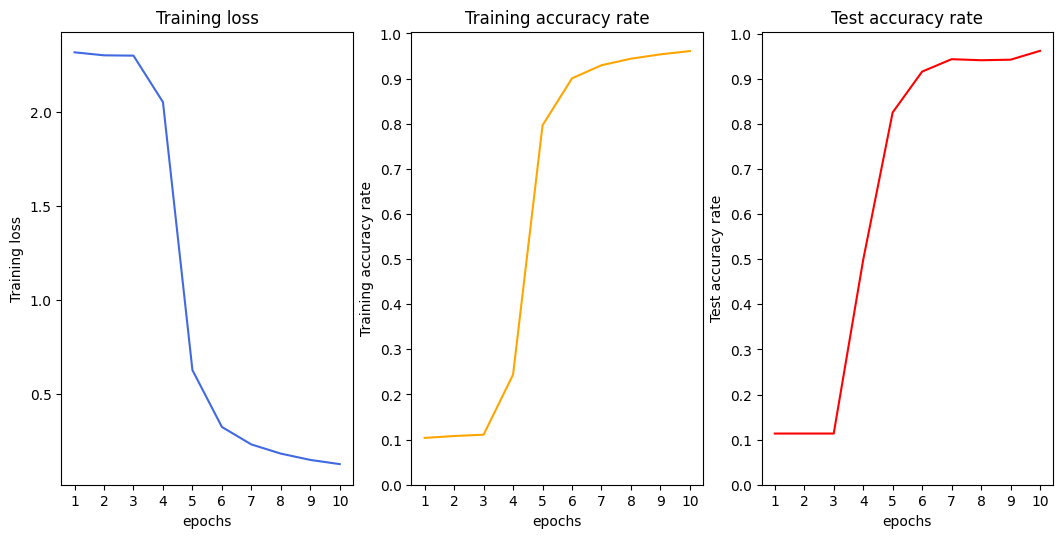

In [10]:
loss_fn = nn.CrossEntropyLoss()
train_loop(Model,loss_fn,10,0.9,train_iter,val_iter,Device)